In [9]:

# Import Required Libraries
# Ensure TensorFlow is installed in your environment: pip install tensorflow numpy pandas scikit-learn matplotlib seaborn shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap


In [10]:
# Step 1: Data Loading
# Column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]


In [11]:

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

In [12]:
# Step 2: Data Preprocessing
# Drop 'difficulty_degree' column as it does not add value
del train["difficulty_degree"]
del test["difficulty_degree"]

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Map 'labels' column to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

In [13]:
# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [14]:

# Step 3: Define TabTransformer Model
# Embedding dimensions
embedding_dim = 32
num_heads = 4
num_transformer_blocks = 2

In [15]:
def build_tabtransformer_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    # Add a sequence length dimension (e.g., sequence length = 1)
    x = tf.expand_dims(inputs, axis=1)  # Shape becomes (batch_size, 1, input_dim)

    # Transformer Encoder Block
    x = layers.Dense(embedding_dim, activation="relu")(x)
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
        x1 = layers.Add()([x, x1])
        x1 = layers.LayerNormalization()(x1)
        x2 = layers.Dense(embedding_dim, activation="relu")(x1)
        x2 = layers.Dropout(0.3)(x2)
        x = layers.Add()([x1, x2])
        x = layers.LayerNormalization()(x)

    # Output Layer
    x = layers.GlobalAveragePooling1D()(x)  # Removes sequence length dimension
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


# Build the model
model = build_tabtransformer_model(x_train.shape[1])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 41)]         0           []                               
                                                                                                  
 tf.expand_dims_1 (TFOpLambda)  (None, 1, 41)        0           ['input_2[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 1, 32)        1344        ['tf.expand_dims_1[0][0]']       
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 1, 32)       16800       ['dense_5[0][0]',                
 eadAttention)                                                    'dense_5[0][0]']          

In [16]:
# Step 4: Train the Model
history = model.fit(
    x_train, y_train,
    epochs=40,
    batch_size=64,
    validation_data=(x_val, y_val)
)


Epoch 1/40
1575/1575 [==============================] - 19s 11ms/step - loss: 0.0515 - accuracy: 0.9808 - val_loss: 0.0283 - val_accuracy: 0.9895
Epoch 2/40
1575/1575 [==============================] - 16s 10ms/step - loss: 0.0305 - accuracy: 0.9885 - val_loss: 0.0282 - val_accuracy: 0.9899
Epoch 3/40
1575/1575 [==============================] - 16s 10ms/step - loss: 0.0269 - accuracy: 0.9899 - val_loss: 0.0223 - val_accuracy: 0.9924
Epoch 4/40
1575/1575 [==============================] - 16s 10ms/step - loss: 0.0244 - accuracy: 0.9910 - val_loss: 0.0195 - val_accuracy: 0.9927
Epoch 5/40
1575/1575 [==============================] - 16s 10ms/step - loss: 0.0221 - accuracy: 0.9920 - val_loss: 0.0181 - val_accuracy: 0.9937
Epoch 6/40
1575/1575 [==============================] - 16s 10ms/step - loss: 0.0211 - accuracy: 0.9927 - val_loss: 0.0202 - val_accuracy: 0.9923
Epoch 7/40
1575/1575 [==============================] - 16s 10ms/step - loss: 0.0200 - accuracy: 0.9929 - val_loss: 0.0174 -

705/705 [==============================] - 3s 4ms/step - loss: 1.5269 - accuracy: 0.7879
Test Loss: 1.5269215106964111, Test Accuracy: 0.7878814935684204


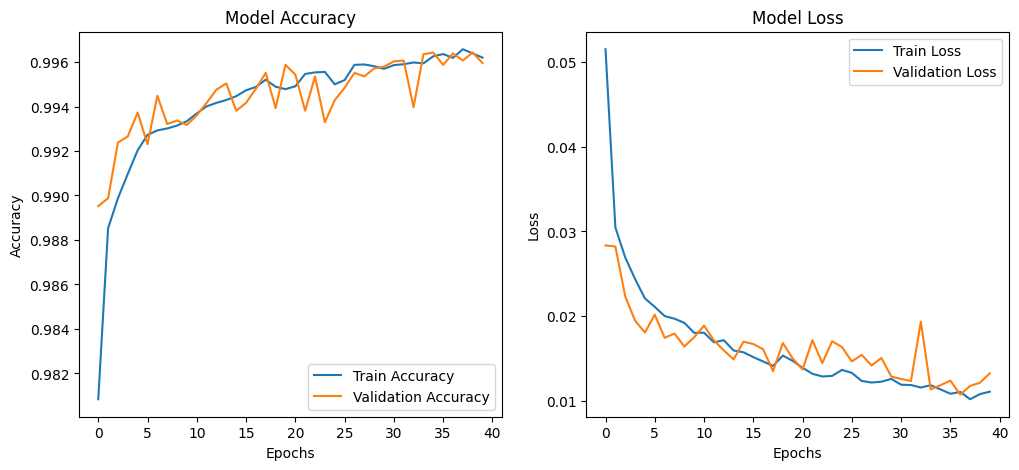

In [17]:
# Step 5: Evaluate the Model
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Step 6: Visualizations
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

705/705 [==============================] - 3s 4ms/step


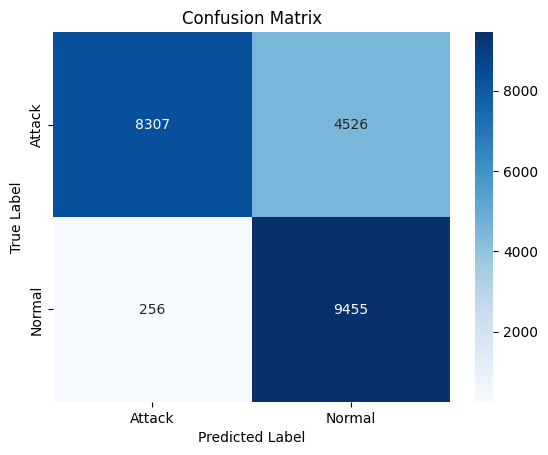

              precision    recall  f1-score   support

      Attack       0.97      0.65      0.78     12833
      Normal       0.68      0.97      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544



In [18]:
# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))



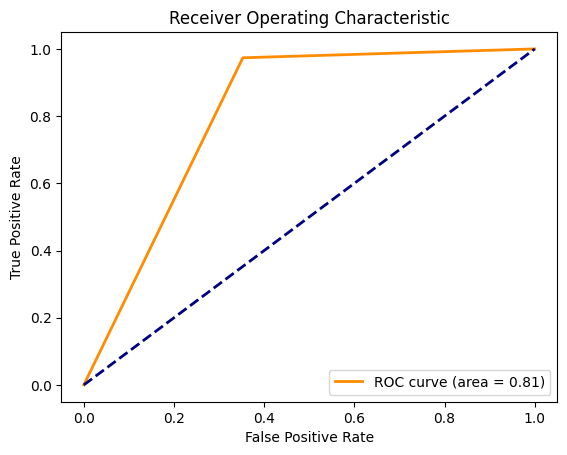

In [19]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()



In [ ]:
# Step 7: SHAP Analysis
# Explain predictions with SHAP
explainer = shap.KernelExplainer(model.predict, X_test[:100])  # Use a subset for SHAP due to compute constraints
shap_values = explainer.shap_values(X_test[:100])

# Summary Plot
shap.summary_plot(shap_values[0], X_test[:100], feature_names=train.columns[:-1])

# Force Plot (First Instance)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test[:1], feature_names=train.columns[:-1])

# Feature Importance Plot
shap.summary_plot(shap_values, X_test[:100], plot_type="bar", feature_names=train.columns[:-1])


4/4 [==============================] - 0s 5ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

6600/6600 [==============================] - 27s 4ms/step


  1%|          | 1/100 [00:30<50:53, 30.84s/it]

6600/6600 [==============================] - 30s 4ms/step


  2%|▏         | 2/100 [01:02<51:14, 31.38s/it]

6600/6600 [==============================] - 28s 4ms/step


  3%|▎         | 3/100 [01:33<50:04, 30.98s/it]

6600/6600 [==============================] - 28s 4ms/step


  4%|▍         | 4/100 [02:02<48:49, 30.52s/it]

6600/6600 [==============================] - 28s 4ms/step


  5%|▌         | 5/100 [02:32<47:54, 30.25s/it]

6600/6600 [==============================] - 27s 4ms/step


  6%|▌         | 6/100 [03:02<47:03, 30.04s/it]

6600/6600 [==============================] - 28s 4ms/step


  7%|▋         | 7/100 [03:32<46:29, 29.99s/it]

6600/6600 [==============================] - 27s 4ms/step


  8%|▊         | 8/100 [04:01<45:47, 29.86s/it]

6600/6600 [==============================] - 28s 4ms/step


  9%|▉         | 9/100 [04:32<45:28, 29.98s/it]

6600/6600 [==============================] - 98s 15ms/step


 10%|█         | 10/100 [06:12<1:17:33, 51.71s/it]

6600/6600 [==============================] - 28s 4ms/step


 11%|█         | 11/100 [06:42<1:06:57, 45.15s/it]

6600/6600 [==============================] - 28s 4ms/step


 12%|█▏        | 12/100 [07:12<59:31, 40.58s/it]  

6600/6600 [==============================] - 29s 4ms/step


 13%|█▎        | 13/100 [07:44<54:58, 37.92s/it]

6600/6600 [==============================] - 30s 5ms/step


 14%|█▍        | 14/100 [08:18<52:40, 36.75s/it]

6600/6600 [==============================] - 31s 5ms/step


 15%|█▌        | 15/100 [08:51<50:34, 35.70s/it]

6600/6600 [==============================] - 29s 4ms/step


 16%|█▌        | 16/100 [09:23<48:06, 34.36s/it]

6600/6600 [==============================] - 29s 4ms/step


 17%|█▋        | 17/100 [09:54<46:14, 33.43s/it]

6600/6600 [==============================] - 28s 4ms/step


 18%|█▊        | 18/100 [10:24<44:20, 32.45s/it]

6600/6600 [==============================] - 29s 4ms/step


 19%|█▉        | 19/100 [10:55<43:15, 32.04s/it]

6600/6600 [==============================] - 30s 5ms/step


 20%|██        | 20/100 [11:28<43:09, 32.37s/it]

6600/6600 [==============================] - 30s 5ms/step


 21%|██        | 21/100 [12:01<42:35, 32.35s/it]

6600/6600 [==============================] - 29s 4ms/step


 22%|██▏       | 22/100 [12:32<41:29, 31.92s/it]

6600/6600 [==============================] - 29s 4ms/step


 23%|██▎       | 23/100 [13:03<40:54, 31.87s/it]

6600/6600 [==============================] - 28s 4ms/step


 24%|██▍       | 24/100 [13:34<39:55, 31.52s/it]

6600/6600 [==============================] - 29s 4ms/step


 25%|██▌       | 25/100 [14:05<39:13, 31.38s/it]

6600/6600 [==============================] - 29s 4ms/step


 26%|██▌       | 26/100 [14:36<38:32, 31.24s/it]

6600/6600 [==============================] - 29s 4ms/step


 27%|██▋       | 27/100 [15:07<38:00, 31.24s/it]

6600/6600 [==============================] - 28s 4ms/step


 28%|██▊       | 28/100 [15:38<37:15, 31.05s/it]

6600/6600 [==============================] - 28s 4ms/step


 29%|██▉       | 29/100 [16:08<36:22, 30.74s/it]

6600/6600 [==============================] - 28s 4ms/step


 30%|███       | 30/100 [16:39<36:04, 30.92s/it]

6600/6600 [==============================] - 30s 4ms/step


 31%|███       | 31/100 [17:11<35:59, 31.29s/it]

6600/6600 [==============================] - 31s 5ms/step


 32%|███▏      | 32/100 [17:45<36:14, 31.98s/it]

6600/6600 [==============================] - 28s 4ms/step


 33%|███▎      | 33/100 [18:16<35:26, 31.74s/it]

6600/6600 [==============================] - 28s 4ms/step


 34%|███▍      | 34/100 [18:46<34:23, 31.26s/it]

6600/6600 [==============================] - 29s 4ms/step


 35%|███▌      | 35/100 [19:19<34:11, 31.57s/it]

6600/6600 [==============================] - 31s 5ms/step


 36%|███▌      | 36/100 [19:52<34:17, 32.15s/it]

6600/6600 [==============================] - 29s 4ms/step


 37%|███▋      | 37/100 [20:23<33:22, 31.79s/it]

6600/6600 [==============================] - 29s 4ms/step


 38%|███▊      | 38/100 [20:55<32:53, 31.83s/it]

6600/6600 [==============================] - 29s 4ms/step


 39%|███▉      | 39/100 [21:26<32:07, 31.60s/it]

6600/6600 [==============================] - 32s 5ms/step


 40%|████      | 40/100 [22:01<32:35, 32.59s/it]

6600/6600 [==============================] - 29s 4ms/step


 41%|████      | 41/100 [22:33<31:47, 32.34s/it]

6600/6600 [==============================] - 30s 5ms/step


 42%|████▏     | 42/100 [23:06<31:36, 32.69s/it]

6600/6600 [==============================] - 31s 5ms/step


 43%|████▎     | 43/100 [23:40<31:18, 32.96s/it]

6600/6600 [==============================] - 28s 4ms/step


 44%|████▍     | 44/100 [24:10<29:56, 32.09s/it]

6600/6600 [==============================] - 31s 5ms/step


 45%|████▌     | 45/100 [24:43<29:48, 32.52s/it]

6600/6600 [==============================] - 28s 4ms/step


 46%|████▌     | 46/100 [25:13<28:35, 31.76s/it]

6600/6600 [==============================] - 29s 4ms/step


 47%|████▋     | 47/100 [25:45<27:57, 31.64s/it]

6600/6600 [==============================] - 29s 4ms/step


 48%|████▊     | 48/100 [26:16<27:17, 31.50s/it]

6600/6600 [==============================] - 30s 5ms/step


 49%|████▉     | 49/100 [26:49<27:19, 32.14s/it]

6600/6600 [==============================] - 30s 5ms/step


 50%|█████     | 50/100 [27:22<26:58, 32.37s/it]

6600/6600 [==============================] - 28s 4ms/step


 51%|█████     | 51/100 [27:53<25:55, 31.74s/it]

6600/6600 [==============================] - 27s 4ms/step


 52%|█████▏    | 52/100 [28:35<27:51, 34.81s/it]

6600/6600 [==============================] - 28s 4ms/step


 53%|█████▎    | 53/100 [29:05<26:11, 33.43s/it]

6600/6600 [==============================] - 27s 4ms/step


 54%|█████▍    | 54/100 [29:47<27:36, 36.02s/it]

6600/6600 [==============================] - 28s 4ms/step


 55%|█████▌    | 55/100 [30:17<25:41, 34.26s/it]

6600/6600 [==============================] - 27s 4ms/step


 56%|█████▌    | 56/100 [30:47<24:08, 32.92s/it]

6600/6600 [==============================] - 27s 4ms/step


 57%|█████▋    | 57/100 [31:17<23:03, 32.17s/it]

6600/6600 [==============================] - 27s 4ms/step


 58%|█████▊    | 58/100 [31:46<21:51, 31.23s/it]

6600/6600 [==============================] - 28s 4ms/step


 59%|█████▉    | 59/100 [32:28<23:33, 34.48s/it]

6600/6600 [==============================] - 28s 4ms/step


 60%|██████    | 60/100 [32:59<22:10, 33.27s/it]

6600/6600 [==============================] - 28s 4ms/step


 61%|██████    | 61/100 [33:29<21:01, 32.36s/it]

6600/6600 [==============================] - 27s 4ms/step


 62%|██████▏   | 62/100 [34:00<20:15, 31.98s/it]

6600/6600 [==============================] - 27s 4ms/step


 63%|██████▎   | 63/100 [34:30<19:15, 31.23s/it]

6600/6600 [==============================] - 27s 4ms/step


 64%|██████▍   | 64/100 [34:59<18:21, 30.60s/it]

6600/6600 [==============================] - 27s 4ms/step


 65%|██████▌   | 65/100 [35:41<19:50, 34.01s/it]

6600/6600 [==============================] - 27s 4ms/step


 66%|██████▌   | 66/100 [36:10<18:27, 32.58s/it]

6600/6600 [==============================] - 28s 4ms/step


 67%|██████▋   | 67/100 [36:41<17:44, 32.24s/it]

6600/6600 [==============================] - 28s 4ms/step


 68%|██████▊   | 68/100 [37:23<18:45, 35.17s/it]

6600/6600 [==============================] - 26s 4ms/step


 69%|██████▉   | 69/100 [37:52<17:08, 33.18s/it]

6600/6600 [==============================] - 27s 4ms/step


 70%|███████   | 70/100 [38:21<15:57, 31.93s/it]

6600/6600 [==============================] - 26s 4ms/step


 71%|███████   | 71/100 [38:49<14:55, 30.89s/it]

6600/6600 [==============================] - 27s 4ms/step


 72%|███████▏  | 72/100 [39:18<14:07, 30.28s/it]

6600/6600 [==============================] - 27s 4ms/step


 73%|███████▎  | 73/100 [39:47<13:28, 29.96s/it]

6600/6600 [==============================] - 2556s 387ms/step


 74%|███████▍  | 74/100 [2:06:24<11:24:34, 1579.78s/it]

6600/6600 [==============================] - 1311s 199ms/step


 75%|███████▌  | 75/100 [2:28:18<10:25:03, 1500.15s/it]

6600/6600 [==============================] - 27s 4ms/step


 76%|███████▌  | 76/100 [2:28:48<7:03:38, 1059.10s/it] 

6600/6600 [==============================] - 28s 4ms/step


 77%|███████▋  | 77/100 [3:06:23<9:03:30, 1417.84s/it]

6600/6600 [==============================] - 98s 15ms/step
